In [1]:
%reload_ext autoreload

In [2]:
%autoreload 2
import math
import numpy as np

from BoseHubbardHamiltonian_class import BoseHubbardHamiltonian

from qiskit.quantum_info import Pauli, Operator
from qiskit.quantum_info import SparsePauliOp

from symmer.operators import PauliwordOp, QuantumState
from symmer.projection import QubitTapering 

import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from symmer.operators import IndependentOp
from scipy.linalg import eigh, eig
import scipy.sparse

C:\Users\User\OneDrive\Desktop\Martina\Tesi\tapenv\lib\site-packages\cotengra\hyperoptimizers\hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
#line lattice 
num_nodes = 3 #number of sites in the lattice 
boundary_condition = BoundaryCondition.OPEN #open lattice
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

In [35]:
param_ratio_list = [] #t/U values list

H_eigenvalues_matrix_1 = [] #original Hamiltonian eigenvalues 
H_eigenvalues_constrained_matrix_1 = [] #selected eigenvalues method 1

In [36]:
H_eigenvalues_matrix = [] #original Hamiltonian eigenvalues 
H_eigenvalues_constrained_matrix = [] #selected eigenvalues method 2

In [25]:
#Hamiltonian of the system given the number of sites in the lattice and the number of qubits
num_qubits = 2
num_nodes = 3
H_instance = BoseHubbardHamiltonian(num_nodes, num_qubits, line_lattice)

energy_values =[1.,1.]
energy_param_ratio = energy_values[0]/energy_values[1]

H_q = H_instance.get_H(energy_values[0],energy_values[1])
H = PauliwordOp.from_qiskit(H_q)
#print(H)

In [41]:
param_ratio_list.append(energy_param_ratio)

In [37]:

H_sparse_matrix = H.to_sparse_matrix
H_array = H_sparse_matrix.toarray()
H_eigenvalues, H_eigenvectors =eig(H_array)

A = np.max(H_eigenvalues) -  np.min(H_eigenvalues)

In [38]:
#METHOD 1 EIGENVALUES SELECTION
H_constrained_sparse = H_q + H_instance.eigenvalues_selection_op(A, 1)
#print(H_constrained_sparse)

In [10]:
#H_constrained_sparse = H_instance.get_H_constrained(energy_values[0],energy_values[1], A , 0)

In [42]:
H_constrained = PauliwordOp.from_qiskit(H_constrained_sparse)
H_constrained_sparse_matrix = H_constrained.to_sparse_matrix
H_constrained_array = H_constrained_sparse_matrix.toarray()
H_constrained_eigenvalues, H_constrained_eigenvectors =eig(H_constrained_array)

H_constrained_ok_eigenvalues = H_constrained_eigenvalues[np.isclose(H_constrained_eigenvalues, H_eigenvalues, atol=1)]
print(H_constrained_ok_eigenvalues) 

[ 2.82842712e+00+0.j -5.91785369e-15+0.j]


In [43]:
H_eigenvalues_matrix_1.append(H_eigenvalues)
H_eigenvalues_constrained_matrix_1.append(H_constrained_ok_eigenvalues)
print(H_eigenvalues_constrained_matrix_1)

[array([3.37339302+0.j]), array([ 2.82842712e+00+0.j, -5.91785369e-15+0.j])]


C:\Users\User\OneDrive\Desktop\Martina\Tesi\tapenv\lib\site-packages\numpy\lib\type_check.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(val).real


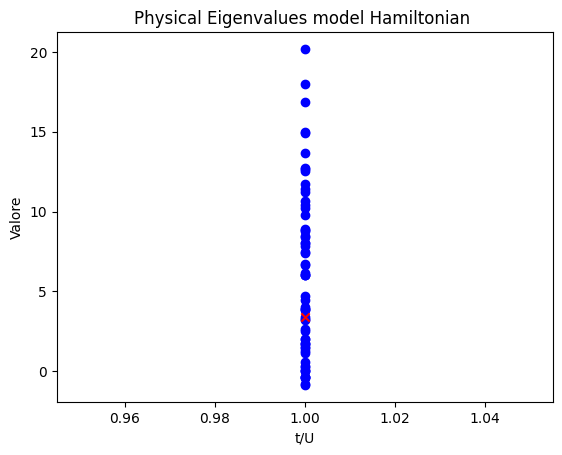

In [44]:
import matplotlib.pyplot as plt
import numpy as np

x_values = np.real(param_ratio_list)
y_values = np.real(H_eigenvalues_matrix_1)
y_constrained = np.real(H_eigenvalues_constrained_matrix_1)

for i in range(len(x_values)):
    plt.scatter([x_values[i]] * len(y_values[i]), y_values[i], marker='o', label=f'Dataset {i+1}', color = 'b')

for i in range(len(x_values)):
    plt.scatter([x_values[i]] * len(y_constrained[i]), y_constrained[i], marker='x', label=f'Constrained Dataset {i+1}', color='red')

plt.xlabel('t/U')
plt.ylabel('Valore')

plt.title('Physical Eigenvalues model Hamiltonian ')


plt.show()

In [45]:
#METHOD 2 EIGENVALUES SELECTION

H_instance.total_number
total_number = PauliwordOp.from_qiskit(H_instance.total_number)

total_number_matrix = H.to_sparse_matrix
total_number_array = H_sparse_matrix.toarray()


H_eigenvectors_normalized = []
for eigenvector in H_eigenvectors:
    norm = np.linalg.norm(eigenvector)  
    eigenvector_normalized = eigenvector / norm
    H_eigenvectors_normalized.append(eigenvector_normalized)

expectation_value = []
for i in range(len(H_eigenvectors_normalized)):
    expectation_value.append(np.dot(np.conj(np.array(H_eigenvectors_normalized[i])).T, np.dot(total_number_array, np.array(H_eigenvectors_normalized[i])))) 


H_eigenvalues_ok = []
for i in range(len(H_eigenvectors)):
    if expectation_value[i] <= 3 and np.isclose(expectation_value[i], np.round(expectation_value[i])) :
        H_eigenvalues_ok.append(H_eigenvalues[i])



In [46]:
H_eigenvalues_matrix.append(H_eigenvalues)
#print(H_eigenvalues_matrix)
H_eigenvalues_constrained_matrix.append(H_eigenvalues_ok)

C:\Users\User\OneDrive\Desktop\Martina\Tesi\tapenv\lib\site-packages\numpy\lib\type_check.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(val).real


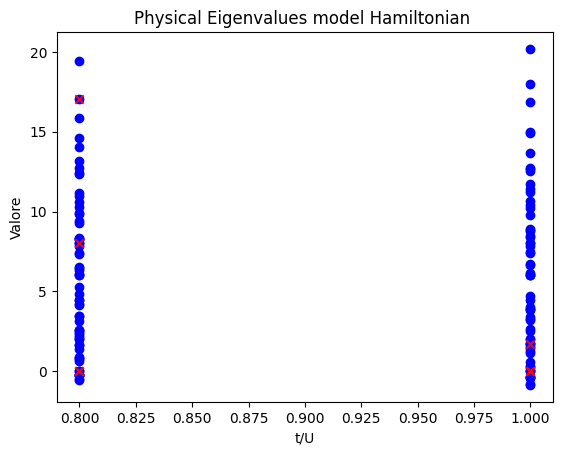

In [33]:
import matplotlib.pyplot as plt
import numpy as np

x_values = np.real(param_ratio_list)
y_values = np.real(H_eigenvalues_matrix)
y_constrained = np.real(H_eigenvalues_constrained_matrix)

for i in range(len(x_values)):
    plt.scatter([x_values[i]] * len(y_values[i]), y_values[i], marker='o', label=f'Dataset {i+1}', color = 'b')

for i in range(len(x_values)):
    plt.scatter([x_values[i]] * len(y_constrained[i]), y_constrained[i], marker='x', label=f'Constrained Dataset {i+1}', color='red')

plt.xlabel('t/U')
plt.ylabel('Valore')

plt.title('Physical Eigenvalues model Hamiltonian ')


plt.show()

In [24]:
#TAPERING

#IndipendentOp represents algebraically independent sets of Pauli operators for stabilizer manipulation/projections
IndependentOp.symmetry_generators(H, commuting_override=True)

1 IZIZIZ

In [18]:
taper_hamiltonian = QubitTapering(H)
taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis()


-1 IZIIII

In [19]:
#TAPERED HAMILTONIAN +

sec_array = [1]
#sec_array = [1,1,1,1,1,1]
ham_tap_p= taper_hamiltonian.taper_it(sector=sec_array)
number_tap_p= taper_hamiltonian.taper_it(sector=sec_array, aux_operator=total_number)
#print(ham_tap_p)
#print("\n",number_tapered)

In [21]:
#TAPERED HAMILTONIAN -

sec_array = [-1]
#sec_array = [-1,-1,-1,-1,-1,-1]
ham_tap_n= taper_hamiltonian.taper_it(sector=sec_array)
number_tap_n= taper_hamiltonian.taper_it(sector=sec_array, aux_operator=total_number)
#print('Tapered Hamiltonian:\n')
#print(ham_tap_p) #sector = -1